In [1]:
import numpy as np
import apss_lib
import ppplot
import matplotlib.pyplot as mpl
%matplotlib inline

2020-04-10 19:24:07.086628


In [2]:
##### SIMPLE TESTS
#dasol = 19 #56 #19 #65 18
#for win in [500,1000,2000]:
#    #apss_lib.analyze_pressure(soltab=[dasol],sfxtab=[""],recalculate=True,datatype="mws",window=win)
#    apss_lib.analyze_pressure(soltab=[dasol],sfxtab=[""],recalculate=True,datatype="pds",window=win)
##data = apss_lib.getsol(345,var="PRE") ; print np.max(data["PRESSURE_FREQUENCY"])

In [3]:
seasontab = [""] ## for all 
#seasontab = ["jgr"] ; solboundtab = [(1,400)] # would be better with a dictionary with label season
#seasontab = ["sequence1","sequence2","sequence3"]
#solboundtab = [(1,40),(41,160),(161,400)] # would be better with a dictionary with label season

In [4]:
#!mkdir outputjgr
#!mkdir outputjgr/pdf_sol_to_sol
#!mkdir outputjgr/txt_sol_to_sol
#!mkdir outputjgr/pdf_stats
#!mkdir outputsequence1
#!mkdir outputsequence1/pdf_sol_to_sol
#!mkdir outputsequence1/txt_sol_to_sol
#!mkdir outputsequence1/pdf_stats
#!mkdir outputsequence2
#!mkdir outputsequence2/pdf_sol_to_sol
#!mkdir outputsequence2/txt_sol_to_sol
#!mkdir outputsequence2/pdf_stats
#!mkdir outputsequence3
#!mkdir outputsequence3/pdf_sol_to_sol
#!mkdir outputsequence3/txt_sol_to_sol
#!mkdir outputsequence3/pdf_stats

In [5]:
if seasontab != [""]:
    soltab, ratiotab = np.loadtxt("./sol_.txt",unpack=True)
    ns = len(seasontab)
    for iii in range(ns):    
        season = seasontab[iii]
        ssol,esol = solboundtab[iii]
        ###
        print season
        dafile = open("./sol_"+season+".txt","w")
        solinterv = np.arange(ssol,esol+1,1)
        for sol in solinterv:
            w = (soltab == sol)
            dafile.write( '%03d %5.3f\n' % (soltab[w][0],ratiotab[w][0]))
        dafile.close()

In [6]:
for season in seasontab:
    
    ### create event structured arrays
    dtype = np.dtype([('drop',float), ('ltst',float), ('sol',int), ('utc','S23'), ('ratio',float)])
    events = np.array([],dtype=dtype)

    ### ratio: full sols have ratio=1
    sol, ratio = np.loadtxt("./sol_"+season+".txt",unpack=True)

    for iii in np.arange(sol.size):
    
        #print sol[iii]
        if ratio[iii] > 0.5:
      
            fifi, output = apss_lib.namefile(sol[iii],"")
            ddfile = "./output/txt_per_sol/"+output+"DD_3.txt"
    
            ltst = np.loadtxt(ddfile,unpack=True,dtype=str,usecols=(2))
            ltst = apss_lib.ltstfloat(ltst)
    
            drop = np.loadtxt(ddfile,unpack=True,usecols=(1))
            utc = np.loadtxt(ddfile,unpack=True,usecols=(3),dtype='S23')
        
            nnn = drop.size
            if nnn > 1:
                for n in np.arange(nnn):
                    element = np.array((drop[n],ltst[n],sol[iii],utc[n],ratio[iii]),dtype=dtype)
                    events = np.append(events,element)
            else:
                events = np.append(events,np.array((drop,ltst,sol[iii],utc,ratio[iii]),dtype=dtype))

    np.save(season+".npy",events)
    print events.size

11275


In [7]:
for season in seasontab:
    
    events = np.load(season+".npy")
    
    ### ordered file
    oevents = np.sort(events, order='drop')
    dafile = open("./output"+season+"/alldrop_ordered.txt","w")
    dafile.write('%6s ; %6s ; %3s ; %23s ; %5s\n' % ("_DROP_","_LTST_","SOL","YYYY-MM-DDTHH:MM:SS.sss","RATIO"))
    for ooo in oevents:
        dafile.write('%6.3f ; %6.3f ; %03d ; %s ; %5.3f\n' % (ooo['drop'],ooo['ltst'],ooo['sol'],ooo['utc'],ooo['ratio']))
    dafile.close()

    dafile = open("./output"+season+"/alldrop_ordered_latex.txt","w")
    dafile.write('%6s & %6s & %3s \\\\ \n' % (" DROP "," LTST ","SOL"))
    for ooo in oevents[0:10]:
        dafile.write('%6.3f & %6.3f & %03d \\\\ \n' % (ooo['drop'],ooo['ltst'],ooo['sol']))
    dafile.close()

MIN,MAX LTST 8.000555555555556 16.636944444444445
MIN,MAX DROP -9.183 -0.295
MEAN =  11.775663127413127
STD =  1.6335187755062948
MEAN =  12.030099292490755
STD =  1.6487305492854205


<Figure size 864x432 with 0 Axes>

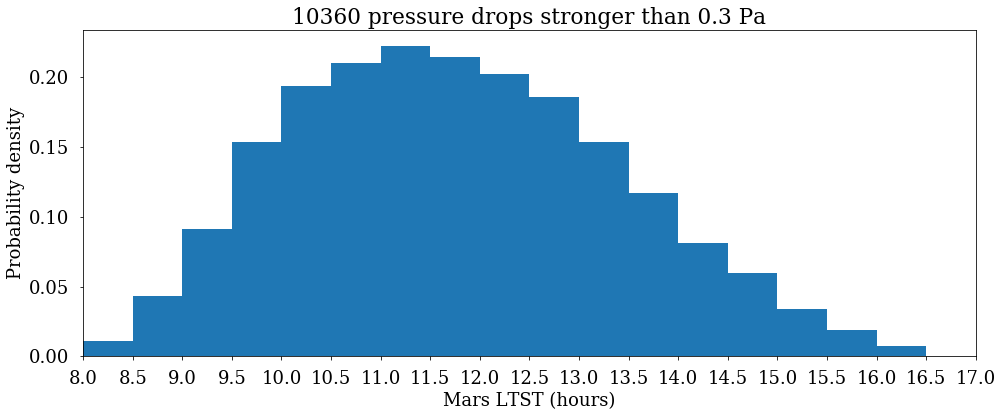

<Figure size 864x432 with 0 Axes>

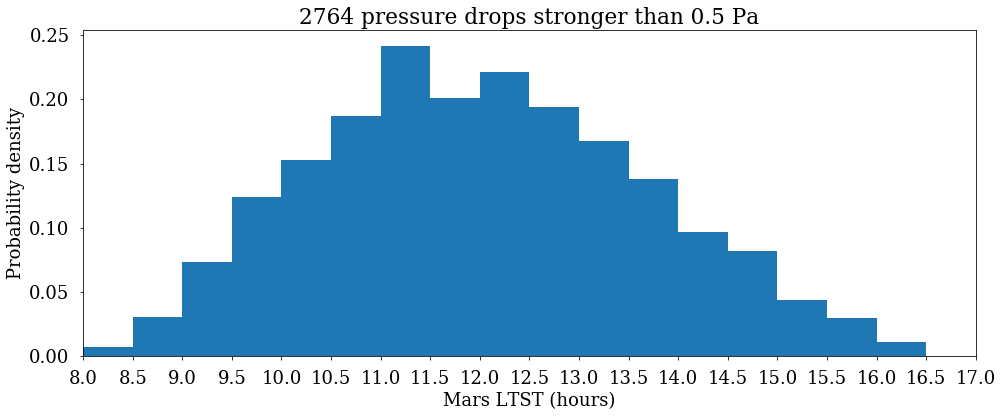

In [8]:
for season in seasontab:

    events = np.load(season+".npy")
    print "MIN,MAX LTST",np.min(events['ltst']),np.max(events['ltst'])
    print "MIN,MAX DROP",np.min(events['drop']),np.max(events['drop'])  

    for limdrop in [0.3,0.5]:
    
        ################# LT HISTOGRAM
        nbins = 18
        ppplot.changefont(18)
        mpl.figure(figsize=(12,6))
        ##############################################
        ## drops stronger than limdrop
        ## + complete sols
        idx = (events['drop'] < -limdrop)*(events['ratio'] > 0.99)
        w = np.where(idx)
        what_hist = events['ltst'][w]
        ##############################################
        ppplot.figuref(x=16,y=6)
        dabins = np.linspace(8,17,nbins+1)
        #dabins = 'auto'
        n, bins, patches = mpl.hist(what_hist,bins=dabins,density=True)
        foo = mpl.ylabel("Probability density")
        foo = mpl.xlabel("Mars LTST (hours)")
        foo = mpl.xticks(bins)
        foo = mpl.title("%i pressure drops stronger than %.1f Pa" % (what_hist.size, limdrop))
        foo = mpl.xlim(xmin=8,xmax=17)

        print "MEAN = ",np.mean(what_hist)
        print "STD = ",np.std(what_hist)
        #from scipy.stats import norm
        #f_x = norm.pdf(bins, np.mean(what_hist), np.std(what_hist))
        #x = bins
        #mpl.plot(x,f_x)
        ####
        ##from scipy.stats import poisson
        ##X = np.arange(6,19)
        ##mpl.plot( X, poisson.pmf(X,np.mean(what_hist)), 'r-' )
        ####
        ppplot.save(mode="pdf",filename="ltst_hist_%02d"%(limdrop*10.),folder='./output'+season+'/pdf_stats/')

435.132
('MPFdP', 'MPFEvSol', 'PHXdP', 'PHXEvSol', 'MSLdP', 'MSLEvSol')


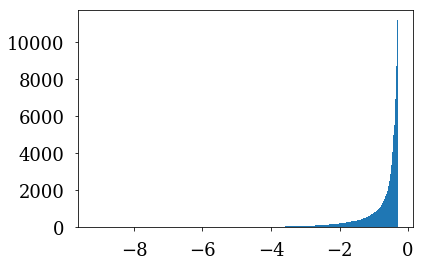

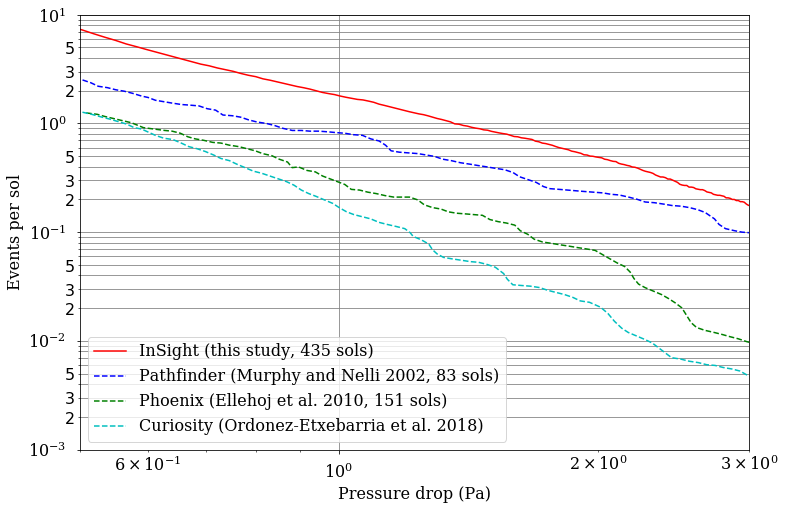

In [9]:
for season in seasontab:

    events = np.load(season+".npy")

    sol, ratio = np.loadtxt("./sol_"+season+".txt",unpack=True)
    nsol = np.sum(ratio)
    print nsol
    ################# LT HISTOGRAM
    limdrop = 0.3

    w = np.where(events['drop'] <= -limdrop)
    what_hist = events['drop'][w]
    n, bins, patches = mpl.hist(what_hist,cumulative=True,bins='auto')
    bins = bins[:-1]
    ppplot.changefont(16)
    fig = ppplot.figuref(x=12,y=8)
    pl = ppplot.plot1d(fig=fig)
    pl.f = n/nsol
    pl.x = -bins
    pl.logx = True
    pl.logy = True
    pl.ymin = 0.001 # Fig15 OE18
    pl.ymax = 10 
    pl.xmin = 0.5
    pl.xmax = 3 #5
    pl.marker = ''
    pl.ylabel = "Events per sol"
    pl.xlabel = 'Pressure drop (Pa)'
    pl.color = 'r'
    pl.legend = "InSight (this study, %i sols)" % (nsol)
    pl.make()

    NSYdP = pl.x
    NSYEvSol = pl.f

    datafile = "/home/aspiga/data/InSight/Ordonez_VortexStats_RL190225.csv"

    data = np.genfromtxt(datafile,dtype=None,names=True,delimiter=',',filling_values=(np.nan))
    print data.dtype.names

    pl.x = data['MPFdP']
    pl.f = data['MPFEvSol']
    pl.color = "b"
    pl.linestyle = '--'
    pl.legend = "Pathfinder (Murphy and Nelli 2002, 83 sols)"
    pl.make()

    pl.x = data['PHXdP']
    pl.f = data['PHXEvSol']
    pl.color = "g"
    pl.linestyle = '--'
    pl.legend = "Phoenix (Ellehoj et al. 2010, 151 sols)"
    pl.make()

    pl.x = data['MSLdP']
    pl.f = data['MSLEvSol']
    pl.color = "c"
    pl.linestyle = '--'
    pl.legend = "Curiosity (Ordonez-Etxebarria et al. 2018)"
    pl.make()

    ppplot.save(filename="./output"+season+"/pdf_stats/cumudrops",mode="pdf")



In [10]:
from ddhist import histodd
bintab = [7,12,30,50]
bintab = [12,30,50]
#bintab = [7,12,30,50,100]
#bintab = [7,12,30,50,100,200]
#bintab = [200]

dafile = open("allDD_1.txt","w")
for drop in events['drop']:
    dafile.write('%5.3f ; %5.3f ; %5.3f ; %5.3f ; %5.3f ; %5.3f\n' % (10,10,-drop,10,10,10))
dafile.close()

for season in seasontab:

    events = np.load(season+".npy") 

    for limdrop in [0.3,1.0]:
       
        for nb in bintab:
            histodd("allDD",drop=True,limrest=None,limtime=None,
                limwind=None,nbins=nb,limdrop=limdrop,\
                folder="./output"+season+"/pdf_stats/")

### limrest: restrict limit (multiple of dx) -- greater equal
### limtime: use only data earlier than this local time 
### limdrop: use only data with deeper drop than value -- 0.5 to avoid false positives
### limwind: use only data with friction velocity larger than this value


[ 0.3         0.44497191  0.66        0.9789382   1.452       2.15366404
  3.1944      4.73806089  7.02768    10.42373396 15.460896   22.9322147
 34.0139712 ]
exponent 3.8040623424671707 variance % 0.016729183926925423
fit 7224 real 7226 pc   0 ipc   0
fit 2392 real 2373 pc   1 ipc   0
fit  792 real  815 pc   3 ipc   1
fit  262 real  408 pc  56 ipc   2
fit   87 real  202 pc 133 ipc   6
fit   29 real  116 pc 304 ipc  17
fit   10 real   46 pc 384 ipc  53
fit    3 real   13 pc 313 ipc 159
fit    1 real    4 pc 284 ipc 480


/home/aspiga/soft/conda/miniconda2/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[  0.3          0.36742346   0.45         0.55113519   0.675
   0.82670279   1.0125       1.24005418   1.51875      1.86008127
   2.278125     2.79012191   3.4171875    4.18518287   5.12578125
   6.2777743    7.68867187   9.41666145  11.53300781  14.12499217
  17.29951172  21.18748826  25.94926758  31.78123238  38.92390137
  47.67184857  58.38585205  71.50777286  87.57877808 107.26165929
 131.36816711]
exponent 3.643316712816896 variance % 0.029453867764180904
fit 4585 real 4562 pc   1 ipc   0
fit 2683 real 2778 pc   4 ipc   0
fit 1570 real 1533 pc   2 ipc   0
fit  919 real  797 pc  13 ipc   1
fit  538 real  474 pc  12 ipc   1
fit  315 real  313 pc   0 ipc   2
fit  184 real  224 pc  22 ipc   3
fit  108 real  165 pc  53 ipc   5
fit   63 real  118 pc  87 ipc   8
fit   37 real   84 pc 128 ipc  14
fit   22 real   63 pc 192 ipc  23
fit   13 real   40 pc 217 ipc  40
fit    7 real   29 pc 293 ipc  68
fit    4 real   11 pc 154 ipc 116
fit    3 real    4 pc  58 ipc 198
fit    1 real    6 pc 305

In [11]:
def create_file_drop(soltab,file="test.txt",limdrop=0.0):
  dafile = open(file,"w")
  dafile.write('SOL RATIO N_D MAXdP\n')

  for dasol in soltab:
    fifi, output = apss_lib.namefile(dasol,"")
    ddfile = "./output/txt_per_sol/"+output+"DD_3.txt"
    drop = np.loadtxt(ddfile,unpack=True,usecols=(1))
    selectdrop = drop[drop <= -limdrop]
    ndrop = len(selectdrop)
    if ndrop > 0:
      extdrop = np.min(selectdrop)
    else:
      extdrop = 0.
    daind = np.where(sol == dasol)
    daratio = ratio[daind]
    
    try:
        dafile.write( '%03d %5.3f %03d %4.2f\n' % (dasol,daratio,ndrop,extdrop))
    except:
        print dasol
        print dasol,daratio,ndrop,extdrop
  dafile.close()
  return

for season in seasontab:
    sol, ratio = np.loadtxt("./sol_"+season+".txt",unpack=True)
    w = np.where(ratio > 0.5) # select sols with sufficient coverage
    create_file_drop(sol[w],file="./output"+season+"/txt_sol_to_sol/solDD_above_0p3.txt",limdrop=0.3)
    create_file_drop(sol[w],file="./output"+season+"/txt_sol_to_sol/solDD_above_0p5.txt",limdrop=0.5)
    create_file_drop(sol[w],file="./output"+season+"/txt_sol_to_sol/solDD_above_1p0.txt",limdrop=1.0)
    create_file_drop(sol[w],file="./output"+season+"/txt_sol_to_sol/solDD_above_2p0.txt",limdrop=2.0)

/home/aspiga/soft/conda/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


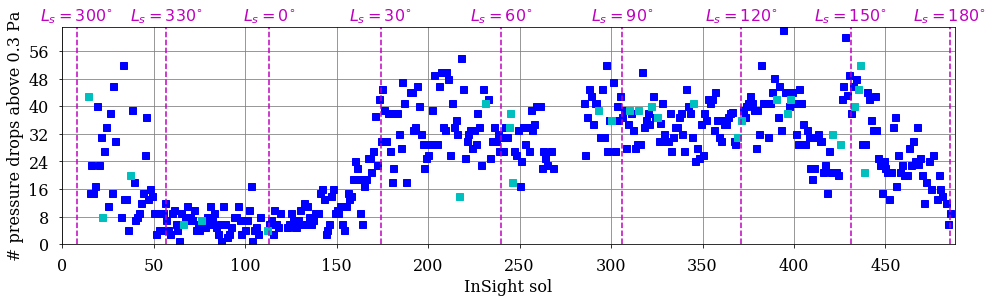

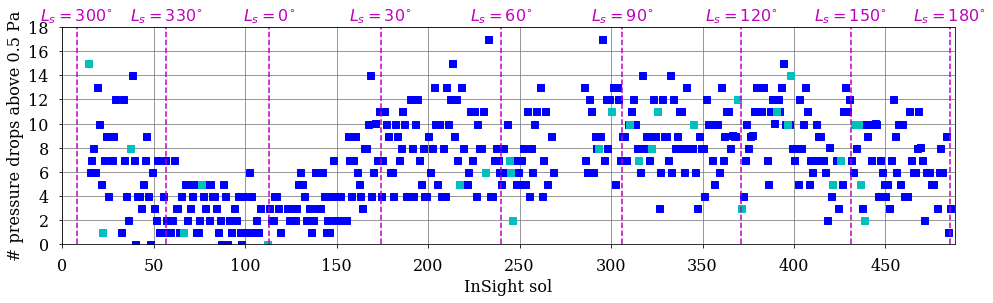

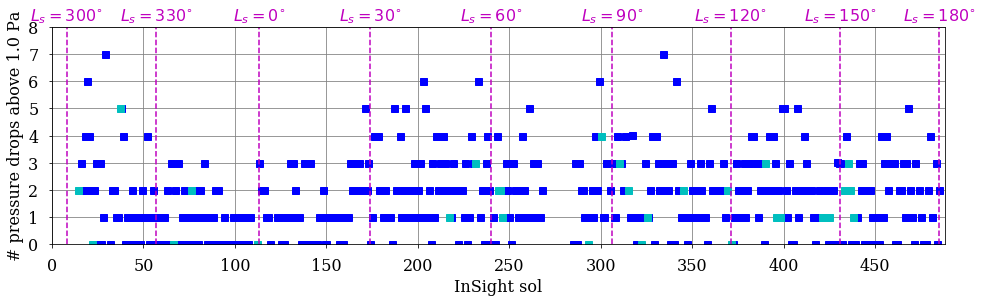

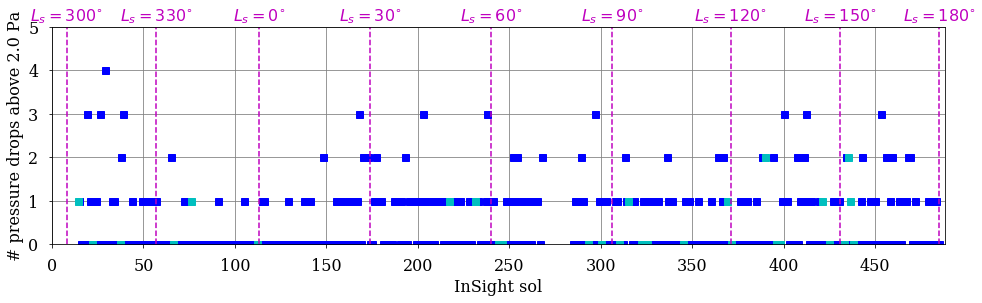

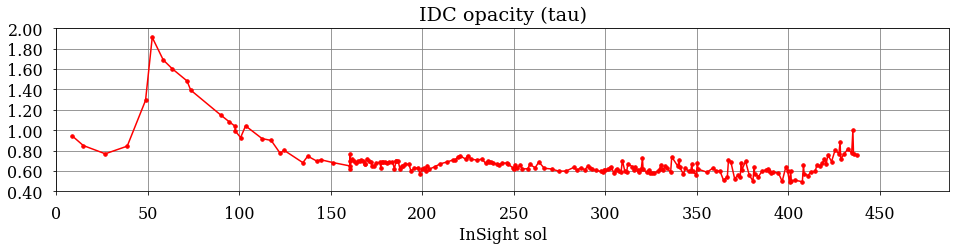

In [12]:
## corrected variability
nx = 16 #32 #24 #16
ny = 4 #6
lim = 0.99 # to select regular (complete) sols

#ppplot.changefont(18)
ppplot.changefont(16)
ppplot.changemarkersize(7)

stab = ["above_0p3","above_0p5","above_1p0","above_2p0"]
#stab = ["above_0p3"]

#for season in seasontab:
ns = len(seasontab)
for iii in range(ns):    

    season = seasontab[iii]
    if seasontab != [""]:
        ssol,esol = solboundtab[iii]
    else:
        ssol,esol = sol[0]  - 1.0, sol[-1] #+ 1.

    for sss in stab:

        sol, ratio, ndd, extdrop = np.loadtxt("./output"+season+"/txt_sol_to_sol/solDD_"+sss+".txt",unpack=True,skiprows=1)
        fig = ppplot.figuref(x=nx,y=ny)
        pl = ppplot.plot1d(fig=fig)
        #pl.xmin = sol[0]  - 1.0
        #pl.xmax = sol[-1] + 1.0
        pl.xmin = ssol
        pl.xmax = esol+1      
        pl.nxticks = 10
        pl.ymin = 0
        pl.ymax = np.max(ndd/ratio)+1
        pl.nyticks = np.min([pl.ymax - pl.ymin + 1, 10])
        pl.fmt = '%.0f'
        pl.xlabel = "InSight sol"
        pl.ylabel = r'# pressure drops ' + sss.replace("p",".").replace("_"," ") + " Pa" #per hour'
        pl.linestyle = ""
        pl.marker = "s"
        #pl.title = "pressure drops " + sss.replace("p",".").replace("_"," ") + " Pa"

        ##########################
        ## regular points first
        w = np.where(ratio >= lim)
        pl.f = ndd[w]/ratio[w]
        pl.x = sol[w]
        pl.color = "b"
        pl.make()

        ##########################
        ## reconstructed points second
        w = np.where( (0.5 < ratio) * (ratio <= lim) )
        pl.f = np.floor(ndd[w]/ratio[w])
        pl.x = sol[w]
        pl.color = "c"
        pl.make()

        for tt in apss_lib.ttab:
            sol,ls = tt
            if pl.xmin < sol < pl.xmax:
                pl.x, pl.f = [sol,sol], [pl.ymin,pl.ymax]
                pl.marker, pl.linestyle = "", "--"
                pl.color = 'm'    
                pl.ax.text(sol,pl.ymax*1.05,r'$L_s=%i^{\circ}$'%(ls),\
                    color = pl.color,horizontalalignment='center',verticalalignment='center',\
                    fontsize=16)
                #pl.ax = apss_lib.add_stripes(pl.ax)
                pl.make()
   
        ppplot.save(filename="drop_dtdvar_"+sss,mode="pdf",folder="./output"+season+"/pdf_sol_to_sol/")

    savmin = pl.xmin
    savmax = pl.xmax
    savtic = pl.nxticks

    fifi = "/home/aspiga/data/InSight/nsyt_tau_report.txt"
    fifi = "https://gemelli.colorado.edu/~lemmon/nsyt_tau_report.txt"
    data = np.genfromtxt(fifi,dtype=None,names=True,skip_footer=1)
    #print data["TAU"]
    ppplot.changefont(16)
    ny = ny*0.75
    fig = ppplot.figuref(x=nx,y=ny)
    pl = ppplot.plot1d(fig=fig)
    pl.f = data["TAU"]
    pl.x = data["SolLMST24"]
    pl.linestyle = ''
    pl.marker = '.'
    pl.xmin = savmin
    pl.xmax = savmax
    pl.nxticks = savtic
    pl.ymin, pl.ymax, pl.nyticks = 0.4,2.0,8
    #pl.ylabel = r'Pressure (Pa) minus $P_{min}=%i$ Pa' % (np.min(pp))
    pl.title = r'IDC opacity (tau)'
    pl.xlabel = 'InSight sol'
    pl.fmt = "%.2f"
    pl.color = "r"
    pl.marker = "."
    pl.linestyle = "-"
    pl.make()

    ppplot.save(filename="tau",mode="pdf",folder="./output"+season+"/")

apss_lib.py:210: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  w = np.where(data[name] == -9999)


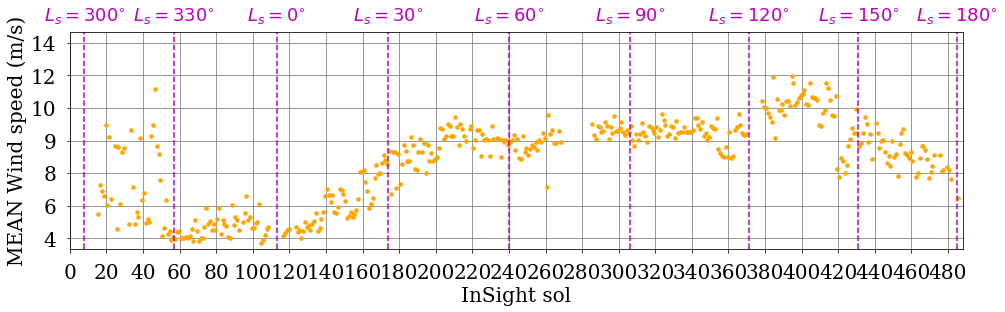

In [13]:
if seasontab == [""]:
    apss_lib.verbose = False
    outy,outx = apss_lib.multisol(pds=True,solini=int(savmin),solsol=int(savmax-savmin+1),code="HWS",ttinter=[[9,16]],\
                        compute="mean",filename="./output/mean_wind_speed",ymin=4,ymax=14,\
                        addls=True,fmt="%.0f",tcinter=["orange"],marker=".")

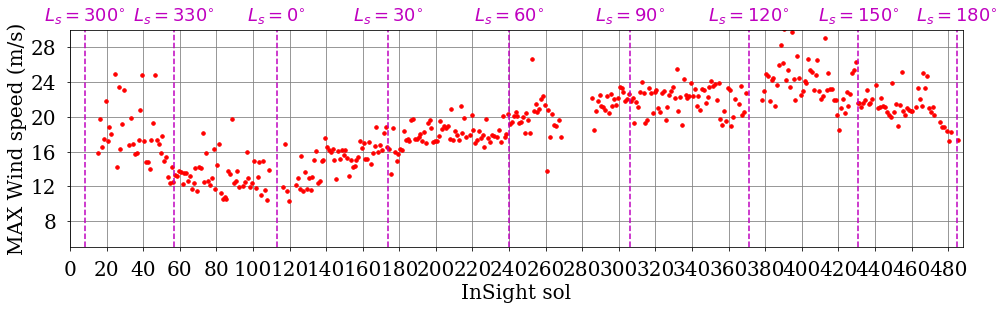

In [14]:
if seasontab == [""]:
    apss_lib.verbose = False
    outy,outx = apss_lib.multisol(pds=True,solini=int(savmin),solsol=int(savmax-savmin+1),code="HWS",ttinter=[[9,16]],\
                        compute="max",filename="./output/max_wind_speed",ymin=5,ymax=30,\
                        addls=True,fmt="%.0f",tcinter=["red"],marker=".")

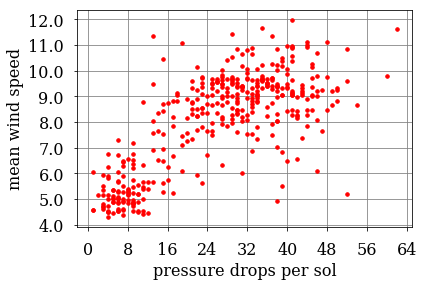

In [14]:
if seasontab == [""]:

    import numpy as np

    fifi = "_0p3"
    #fifi = "_0p5"
    #fifi = "_1p0"

    sol, ratio, ndd, extdrop = np.loadtxt("./output/txt_sol_to_sol/solDD_above"+fifi+".txt",unpack=True,skiprows=1)
    ### select full sols
    w = np.where(ratio > 0.99)


    fff = []
    xxx = []
    count = 0
    for sss in sol[w]:
        dist = np.abs(sss - outx)
        cond = (dist == np.min(dist))
        if np.abs(sss - outx[cond]) > 0.55:
            #print sss, outx[cond]
            pass
        else:
            xxx = np.append(xxx,ndd[w][count])
            #xxx = np.append(xxx,-extdrop[w][count])
            fff = np.append(fff,outy[cond])
            count = count + 1
        
    #print xxx
    #print fff

    import ppplot
    ppplot.changefont(16)
    pl = ppplot.plot1d()
    pl.f = fff #-extdrop[w]
    pl.x = xxx #ndd[w]/ratio[w]
    pl.fmt = "%.1f"
    pl.linestyle = ""
    pl.marker = "."
    #pl.xlabel = "pressure drops per sol"
    #pl.ylabel = "max drop (Pa)"
    pl.ylabel = "mean wind speed"
    pl.xlabel = "pressure drops per sol"
    #pl.ymax = +10.0
    #pl.ymin = +0.0
    #pl.nyticks = pl.ymax - pl.ymin + 1
    pl.color = "r"
    pl.makeshow()




below an intent to be put right after the comparison with other missions, to explain differences in activity between InSight and other sites

In [15]:
if 0 == 1:

    ### a reference for each mission is the 1 Pa statistics
    xx = NSYdP
    xx = xx[np.isfinite(xx)]
    metric = np.abs(xx - 1)
    w = np.where(metric == np.min(metric))
    NSYref = NSYEvSol[w]
    print NSYref

    xx = data['MPFdP']
    xx = xx[np.isfinite(xx)]
    metric = np.abs(xx - 1)
    w = np.where(metric == np.min(metric))
    MPFref = data['MPFEvSol'][w]
    print MPFref

    xx = data['PHXdP']
    xx = xx[np.isfinite(xx)]
    metric = np.abs(xx - 1)
    w = np.where(metric == np.min(metric))
    PHXref = data['PHXEvSol'][w]
    print PHXref

    evpersol = [MPFref,PHXref,NSYref]

### MPF
# MCD_v5.3 with climatology average solar scenario. Ls 163.0deg. Latitude 19.13N Longitude -33.22E Altitude 10.0 m ALS Local time 12.0h
#
#    Convective PBL height (m) ..... 4133.77
#    surface temperature (K) ..... 277.649
#    Convective eddy vertical heat flux at level z (m/s/K) ..... 0.332967
#    Max. upward convective wind within the PBL (m/s) ..... 12.7286
#    Horizontal wind speed (m/s) ..... 7.78237 

### PHX
# MCD_v5.3 with climatology average solar scenario. Ls 113.0deg. Latitude 68.22N Longitude 234.25E Altitude 10.0 m ALS Local time 12.0h
#
#    Convective PBL height (m) ..... 2886.39
#    surface temperature (K) ..... 255.071
#    Convective eddy vertical heat flux at level z (m/s/K) ..... 0.155771
#    Max. upward convective wind within the PBL (m/s) ..... 8.09357
#    Horizontal wind speed (m/s) ..... 1.10399 

### NSY
#MCD_v5.3 with climatology average solar scenario. Ls 320.0deg. Latitude 4.5N Longitude 135.6E Altitude 10.0 m ALS Local time 12.0h
#
#    Convective PBL height (m) ..... 3336.2
#    surface temperature (K) ..... 275.142
#    Convective eddy vertical heat flux at level z (m/s/K) ..... 0.411785
#    Max. upward convective wind within the PBL (m/s) ..... 12.1516
#    Horizontal wind speed (m/s) ..... 6.53559 


    hf = [0.332967,0.155771,0.411785]

    fig = ppplot.figuref(x=4,y=4)
    pl = ppplot.plot1d(fig=fig)
    pl.f = evpersol ; pl.ylabel = "1-Pa drop events per sol"
    pl.x = hf ; pl.xlabel = "Turbulent heat flux at 10 m (m/s/K)"
    pl.fmt = "%.1f"
    pl.nxticks = pl.nyticks = 5
    pl.marker = "o"
    pl.linestyle = ""
    pl.make()
    ppplot.save(filename="cumudrops_hf",mode="pdf")
